## Exemplo 02 - Aplicação de RNN para predição de série temporal de microestações na Amazônia

Neste exemplo, será utilizado das redes neurais recorrentes para imputação de dados climáticas da cidade de Monte Alegre no estado do Pará.

#### Dataset
Os dados das estações meteorológicas das cidades de Monte Alegre, Oriximina e Belterra a partir do ano 1988 à 2018

### Bibliotecas

In [603]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import datetime
from functools import reduce
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

In [604]:
!pip install tensorflow==1.15

In [605]:
# Bibliotecas Keras
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, LSTM, GRU, Embedding, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [606]:
print('Versão do TensorFlow: ',tf.__version__)
print('Versão do Keras: ',tf.keras.__version__)
print('Versão do Pandas: ',pd.__version__)

Versão do TensorFlow:  1.15.0
Versão do Keras:  2.2.4-tf
Versão do Pandas:  0.25.2


## Carregando dados
Os arquivos brutos foram baixados do INMET e armazenados no diretório '/dataset'.

In [607]:
## Leitura Dados
# Monte Alegre
mtal = pd.read_csv('../input/dados_monte_alegre.csv', delimiter=';')
# Belterra
belt = pd.read_csv('../input/dados_belterra.csv', delimiter=';')
# Oriximina
orix = pd.read_csv('../input/dados_oriximina.csv', delimiter=';')

### Preparação dos dados

In [608]:
### Organização dataset
mtal[['day','month','year']] = mtal.Data.str.split('/', n = 3, expand = True)
mtal['day'] = pd.to_numeric(mtal.day)
mtal['month'] = pd.to_numeric(mtal.month)
mtal['year'] = pd.to_numeric(mtal.year)
mtal = mtal.replace([1200,1800],[12,18])

mtal['datetime'] = mtal[['day','month','year','Hora']].apply(lambda row:
                    datetime.datetime(year=row['year'], month=row['month'],day=row['day'],hour=row['Hora']),axis=1)
mtal = mtal.drop(columns=['Data','Hora','day','month','year','Unnamed: 10'])
mtal = mtal.set_index('datetime')
mtal.sort_values('datetime',ascending=True,inplace=True)
mtal = mtal['1988':'2018']

belt[['day','month','year']] = belt.Data.str.split('/', n = 3, expand = True)
belt['day'] = pd.to_numeric(belt.day)
belt['month'] = pd.to_numeric(belt.month)
belt['year'] = pd.to_numeric(belt.year)
belt = belt.replace([1200,1800],[12,18])

belt['datetime'] = belt[['day','month','year','Hora']].apply(lambda row:
                    datetime.datetime(year=row['year'], month=row['month'],day=row['day'],hour=row['Hora']),axis=1)
belt = belt.drop(columns=['Data','Hora','day','month','year','Unnamed: 10'])
belt = belt.set_index('datetime')
belt.sort_values('datetime',ascending=True,inplace=True)
belt = belt['1988':'2018']

orix[['day','month','year']] = orix.Data.str.split('/', n = 3, expand = True)
orix['day'] = pd.to_numeric(orix.day)
orix['month'] = pd.to_numeric(orix.month)
orix['year'] = pd.to_numeric(orix.year)
orix = orix.replace([1200,1800],[12,18])

orix['datetime'] = orix[['day','month','year','Hora']].apply(lambda row:
                    datetime.datetime(year=row['year'], month=row['month'],day=row['day'],hour=row['Hora']),axis=1)
orix = orix.drop(columns=['Data','Hora','day','month','year','Unnamed: 10'])
orix = orix.set_index('datetime')
orix.sort_values('datetime',ascending=True,inplace=True)
orix = orix['1988':'2018']

In [609]:
print('Tamanho do dataframe Monte Alegre: ',mtal.shape[0], ', Variáveis:',mtal.shape[1])
print('Tamanho do dataframe Belterra: ',belt.shape[0], ', Variáveis:',belt.shape[1])
print('Tamanho do dataframe Oriximina: ',orix.shape[0], ', Variáveis:',orix.shape[1])

Tamanho do dataframe Monte Alegre:  33731 , Variáveis: 8
Tamanho do dataframe Belterra:  33038 , Variáveis: 8
Tamanho do dataframe Oriximina:  30147 , Variáveis: 8


In [610]:
## Merge entre os datasets
dfs = [mtal,belt,orix]
dfs_final = reduce(lambda left,right: pd.merge(left,right, on='datetime'),dfs)

# Remover colunas
dfs_final = dfs_final.drop(columns=['Estacao_x','DirecaoVento_x','VelocidadeVento_x','Nebulosidade_x',
                                   'Estacao_y','DirecaoVento_y','VelocidadeVento_y','Nebulosidade_y',
                                   'Estacao','DirecaoVento','VelocidadeVento','Nebulosidade'])

dfs_final = dfs_final.rename(columns={'TempBulboSeco_x':'TempBS_MTA','TempBulboUmido_x':'TempBU_MTA','UmidadeRelativa_x':'UmidR_MTA','PressaoAtmEstacao_x':'Pres_MTA',
                                      'TempBulboSeco_y':'TempBS_BLT','TempBulboUmido_y':'TempBU_BLT','UmidadeRelativa_y':'UmidR_BLT','PressaoAtmEstacao_y':'Pres_BLT',
                                      'TempBulboSeco':'TempBS_ORX','TempBulboUmido':'TempBU_ORX','UmidadeRelativa':'UmidR_ORX','PressaoAtmEstacao':'Pres_ORX'} )
dfs_final.head()

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
datetime,,,,,,,,,,,,
1988-01-01 00:00:00,28.7,24.4,65.0,997.4,26.6,24.6,83.0,990.2,24.2,23.8,96.0,1003.8
1988-01-01 12:00:00,27.9,23.5,68.0,999.9,26.4,25.0,89.0,992.5,26.8,25.4,89.0,1004.1
1988-01-01 18:00:00,33.6,23.5,40.0,998.2,31.8,26.0,62.0,991.0,30.0,27.2,80.0,1002.7
1988-01-02 00:00:00,27.4,24.0,74.0,998.3,27.4,24.4,77.0,990.6,28.4,25.8,80.0,1002.6
1988-01-02 12:00:00,25.0,23.5,88.0,999.7,25.0,24.4,95.0,992.7,26.3,24.8,88.0,1006.2


### Visualização dos dados

Após organizar os dados será necessário visualizar para que se possa definir quais as variáveis mais importantes para a imputação.

Os dados foram plotados e divididos a partir de suas variáveis (Temperatura de Bulbo Seco; Temperatura de Bulbo Umido, Umidade e Pressão Atmosférica)

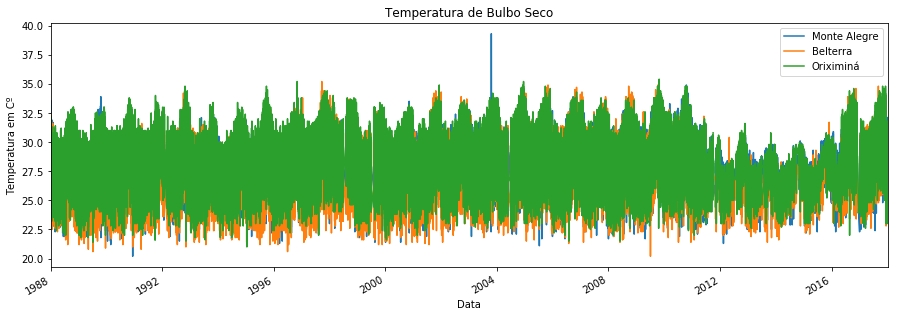

In [611]:
# Visualização do sensor Temperatura Bulbo Seco para as 3 estações
TempBulboS = dfs_final[['TempBS_MTA','TempBS_BLT','TempBS_ORX']].plot(figsize=(15,5),title='Temperatura de Bulbo Seco')
TempBulboS.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Temperatura em Cº')
plt.show()

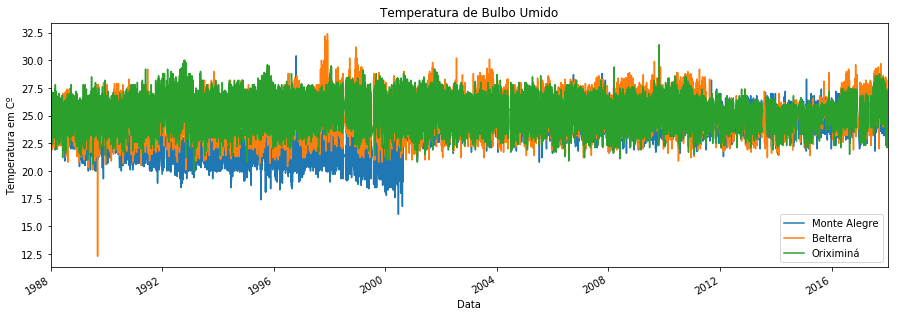

In [612]:
# Visualização do sensor Temperatura Bulbo Umido para as 3 estações
TempBulboU = dfs_final[['TempBU_MTA','TempBU_BLT','TempBU_ORX']].plot(figsize=(15,5),title='Temperatura de Bulbo Umido')
TempBulboU.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Temperatura em Cº')
plt.show()

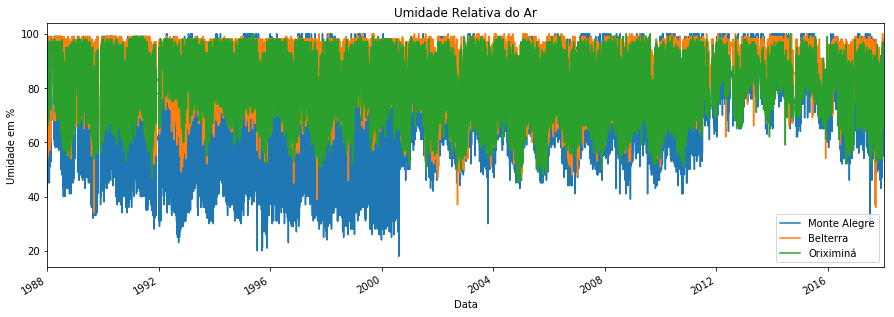

In [613]:
# Visualização do sensor Umidade para as 3 estações
Humid = dfs_final[['UmidR_MTA','UmidR_BLT','UmidR_ORX']].plot(figsize=(15,5),title='Umidade Relativa do Ar')
Humid.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Umidade em %')
plt.show()

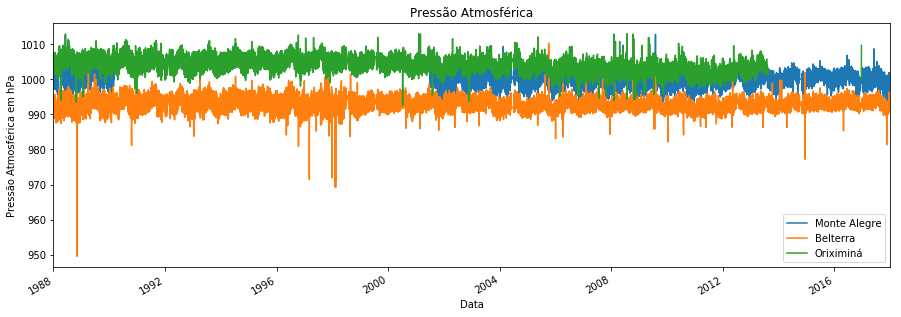

In [614]:
# Visualização do sensor Pressão Atmosférica para as 3 estações
PressaoP = dfs_final[['Pres_MTA','Pres_BLT','Pres_ORX']].plot(figsize=(15,5),title='Pressão Atmosférica')
PressaoP.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

### Correção de outliers

Algumas medições apresentam valores incongruentes com a média dos dados, e para isso será necessário aplicar um método que faça a correção desses dados discrepantes.

In [615]:
# Descrição do DataFrame
dfs_final.describe()

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
count,29921.000000,29821.000000,29643.000000,17608.000000,29864.000000,29704.000000,29561.000000,29905.000000,29924.000000,29774.000000,29621.000000,26592.000000
mean,27.569998,23.646397,71.928685,999.529208,26.712098,24.930127,86.552451,992.661766,27.720659,25.307594,82.005942,1003.821221
std,2.413840,1.602462,16.442361,1.891690,2.583035,1.371070,10.147083,1.866587,2.437576,1.226837,9.848434,2.156429
min,20.200000,16.100000,18.000000,992.500000,20.200000,12.300000,34.000000,949.600000,21.000000,20.000000,45.000000,983.300000
25%,25.800000,22.500000,61.000000,998.200000,24.800000,24.000000,81.000000,991.400000,26.000000,24.400000,76.000000,1002.400000
50%,27.300000,23.900000,74.000000,999.600000,26.200000,24.900000,90.000000,992.600000,27.400000,25.200000,84.000000,1003.700000
75%,29.300000,24.900000,85.000000,1000.900000,28.200000,25.800000,94.000000,993.900000,29.200000,26.200000,90.000000,1005.400000
max,39.300000,30.400000,100.000000,1012.800000,35.200000,32.400000,100.000000,1010.200000,35.400000,31.400000,100.000000,1012.900000


In [616]:
## Remoção de Outliers por quantil
low = .001
high = .9999
quant_df = dfs_final.quantile([low,high])

In [617]:
# Valores que representam os outliers
quant_df

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
0.0010,21.900,18.5820,26.0,993.7607,21.40000,21.00000,51.0,986.20000,22.00000,21.60000,50.0,997.6
0.9999,34.404,28.6018,100.0,1011.1786,34.80137,31.70297,100.0,1001.70096,34.90231,29.80454,100.0,1012.8


In [618]:
# Função para correção dos outliers
filt_df = dfs_final.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)

filt_df.describe()

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
count,29874.000000,29788.000000,29401.000000,17588.000000,29815.000000,29659.000000,29487.000000,29869.000000,29887.000000,29739.000000,29579.000000,26559.000000
mean,27.577844,23.651427,71.790007,999.534234,26.719765,24.935564,86.577746,992.673889,27.726614,25.311436,82.038068,1003.828868
std,2.403255,1.592469,16.256774,1.876396,2.574708,1.359448,10.060455,1.800093,2.429756,1.219155,9.785707,2.133213
min,22.000000,18.600000,27.000000,993.800000,21.500000,21.100000,52.000000,986.300000,22.100000,21.700000,51.000000,997.700000
25%,25.800000,22.500000,61.000000,998.200000,24.900000,24.100000,81.000000,991.400000,26.000000,24.400000,76.000000,1002.400000
50%,27.300000,23.900000,74.000000,999.600000,26.200000,24.900000,90.000000,992.600000,27.400000,25.200000,84.000000,1003.700000
75%,29.300000,24.900000,84.000000,1000.900000,28.200000,25.800000,94.000000,993.900000,29.200000,26.200000,90.000000,1005.400000
max,34.400000,28.600000,99.000000,1010.700000,34.800000,31.700000,99.000000,1001.700000,34.900000,29.800000,99.000000,1012.600000


In [619]:
# Numerode elementos sem registro no DataFrame sem correção
dfs_final.isna().sum()

TempBS_MTA        8
TempBU_MTA      108
UmidR_MTA       286
Pres_MTA      12321
TempBS_BLT       65
TempBU_BLT      225
UmidR_BLT       368
Pres_BLT         24
TempBS_ORX        5
TempBU_ORX      155
UmidR_ORX       308
Pres_ORX       3337
dtype: int64

In [620]:
# Numerode elementos sem registro no DataFrame com correção
filt_df.isna().sum()

TempBS_MTA       55
TempBU_MTA      141
UmidR_MTA       528
Pres_MTA      12341
TempBS_BLT      114
TempBU_BLT      270
UmidR_BLT       442
Pres_BLT         60
TempBS_ORX       42
TempBU_ORX      190
UmidR_ORX       350
Pres_ORX       3370
dtype: int64

In [621]:
# Visualização dos outliers por boxplot dados sem correção
import seaborn as sns

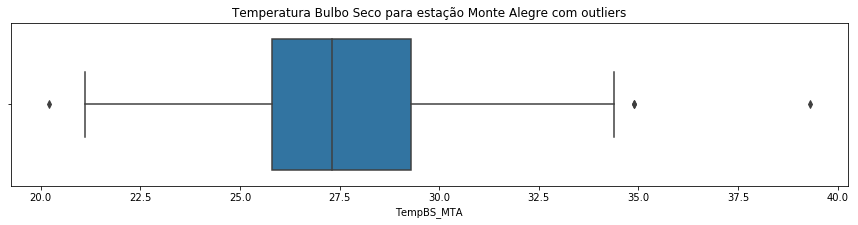

In [622]:
plt.figure(figsize=(15,3))
plt.title('Temperatura Bulbo Seco para estação Monte Alegre com outliers')
sns.boxplot(x=dfs_final['TempBS_MTA'])
plt.show()

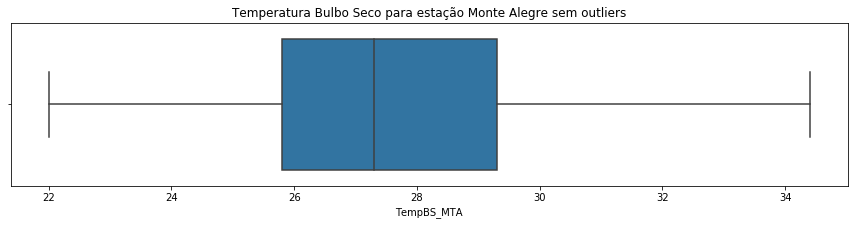

In [623]:
# Visualização dos outliers por boxplot dados com correção
plt.figure(figsize=(15,3))
plt.title('Temperatura Bulbo Seco para estação Monte Alegre sem outliers')
sns.boxplot(x=filt_df['TempBS_MTA'])
plt.show()

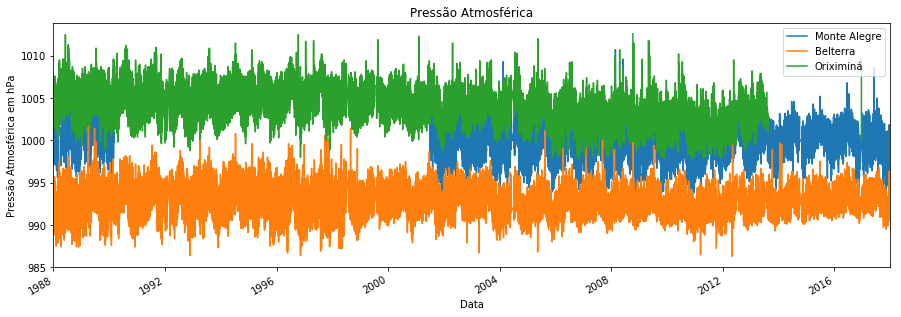

In [624]:
# Visualização do sensor Pressão Atmosférica para as 3 estações
PressaoP = filt_df[['Pres_MTA','Pres_BLT','Pres_ORX']].plot(figsize=(15,5),title='Pressão Atmosférica')
PressaoP.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

## Imputação de dados

Nota-se que no gráfico de Pressão atmosférica existe uma quantidade consideravel de valores nulos para cidade de Monte Alegre, ou seja, será necessário aplicar uma métrica inicial para preencher os dados sem registro, desta forma iremos aplicar uma imputação simples para os dados de Pressão Atmosférica na cidade de Monte Alegre, que consistem em usar os valores das cidades de Belterra e Oriximiná para estimar a os valores de Monte Alegre pela média entre as cidades Belterra e Oriximiná. Como a estação meteorológica de Monte Alegre fica a uma altitude entre as cidades de Oriximiná e e Belterra seu valor estimado por uma imputação simples não sofrera grandes impactos.

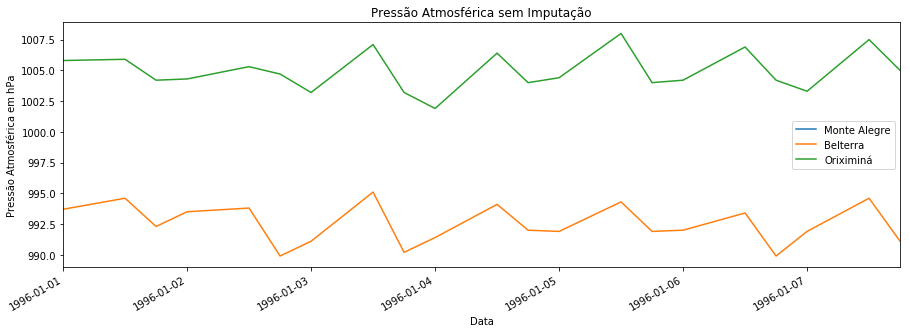

In [625]:
# Exemplo de visualização para imputação
# Exemplo entre os dias 01 e 07 de janeiro de 1996
preE = filt_df[['Pres_MTA','Pres_BLT','Pres_ORX']]['1996/01/01':'1996/01/07'].plot(figsize=(15,5),title='Pressão Atmosférica sem Imputação')
preE.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

In [626]:
# Media entre Belterra e Oriximina
filt_df['Pres_MTA'] = filt_df.Pres_MTA.fillna(filt_df[['Pres_BLT','Pres_ORX']].mean(axis=1))

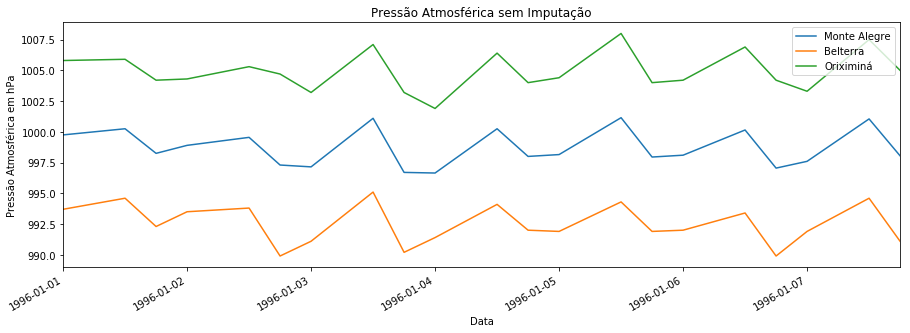

In [627]:
# Exemplo de visualização para imputação
# Exemplo entre os dias 01 e 07 de janeiro de 1996
preE = filt_df[['Pres_MTA','Pres_BLT','Pres_ORX']]['1996/01/01':'1996/01/07'].plot(figsize=(15,5),title='Pressão Atmosférica sem Imputação')
preE.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

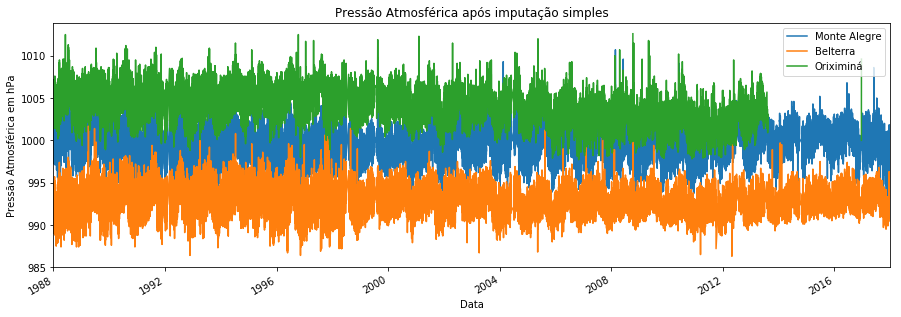

In [628]:
# Visualização do sensor Pressão Atmosférica para as 3 estações
PressaoP = filt_df[['Pres_MTA','Pres_BLT','Pres_ORX']].plot(figsize=(15,5),title='Pressão Atmosférica após imputação simples')
PressaoP.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

In [629]:
# Numerode elementos sem registro no DataFrame com correção
filt_df.isna().sum()

TempBS_MTA      55
TempBU_MTA     141
UmidR_MTA      528
Pres_MTA         0
TempBS_BLT     114
TempBU_BLT     270
UmidR_BLT      442
Pres_BLT        60
TempBS_ORX      42
TempBU_ORX     190
UmidR_ORX      350
Pres_ORX      3370
dtype: int64

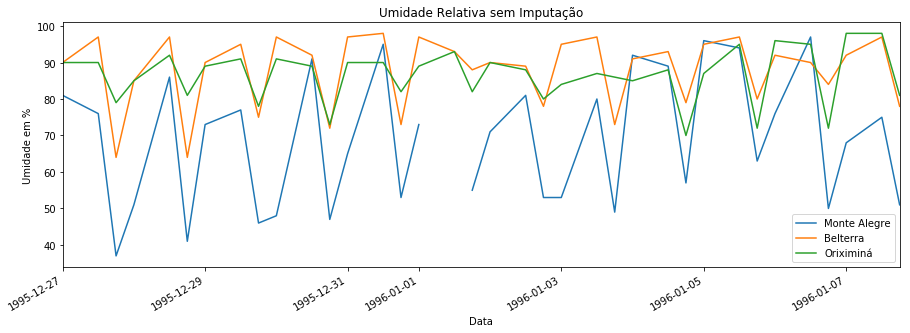

In [630]:
# Exemplo de visualização para imputação
# Exemplo entre os dias 01 e 07 de janeiro de 1996
humE = filt_df[['UmidR_MTA','UmidR_BLT','UmidR_ORX']]['1995/12/27':'1996/01/07'].plot(figsize=(15,5),title='Umidade Relativa sem Imputação')
humE.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Umidade em %')
plt.show()

In [631]:
# Media entre Belterra e Oriximina
filt_df['UmidR_MTA'] = filt_df.UmidR_MTA.fillna(filt_df[['UmidR_BLT','UmidR_ORX']].mean(axis=1))

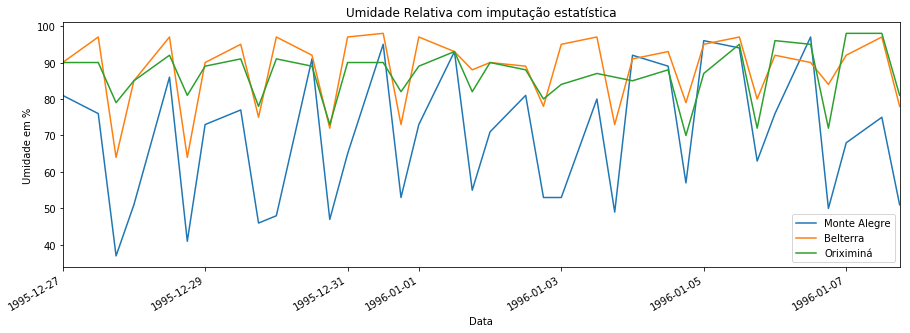

In [632]:
# Exemplo de visualização para imputação
# Exemplo entre os dias 01 e 07 de janeiro de 1996
humE = filt_df[['UmidR_MTA','UmidR_BLT','UmidR_ORX']]['1995/12/27':'1996/01/07'].plot(figsize=(15,5),title='Umidade Relativa com imputação estatística')
humE.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Umidade em %')
plt.show()

### Imputação Multivariada

Devido a alta correlação entre os valores de temperatura é possível aplicar uma imputação multivariada entre os dados.

In [633]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [634]:
imp = IterativeImputer(max_iter=10, random_state=0)

## Imputação para Temperatura Bulbo Seco
timp = imp.fit(filt_df.loc[:,['TempBS_MTA','TempBS_BLT','TempBS_ORX']].to_numpy())
timp = timp.transform(filt_df.loc[:,['TempBS_MTA','TempBS_BLT','TempBS_ORX']].to_numpy())


## Imputação Para Temperatura Bulbo Umido
uimp = imp.fit(filt_df.loc[:,['TempBU_MTA','TempBS_BLT','TempBU_ORX']].to_numpy())
uimp = uimp.transform(filt_df.loc[:,['TempBU_MTA','TempBU_BLT','TempBU_ORX']].to_numpy())

In [635]:
df_final = filt_df.drop(['TempBS_MTA','TempBS_BLT','TempBS_ORX','TempBU_MTA','TempBU_BLT','TempBU_ORX'], axis=1)

In [636]:
df_final['TempBS_MTA'] = timp[:,0]
df_final['TempBS_BLT'] = timp[:,1]
df_final['TempBS_ORX'] = timp[:,2]
df_final['TempBU_MTA'] = uimp[:,0]
df_final['TempBU_BLT'] = uimp[:,1]
df_final['TempBU_ORX'] = uimp[:,2]

In [637]:
df_final.isna().sum()

UmidR_MTA      180
Pres_MTA         0
UmidR_BLT      442
Pres_BLT        60
UmidR_ORX      350
Pres_ORX      3370
TempBS_MTA       0
TempBS_BLT       0
TempBS_ORX       0
TempBU_MTA       0
TempBU_BLT       0
TempBU_ORX       0
dtype: int64

In [638]:
# Removendo os valores nulos
df_final = df_final.dropna()

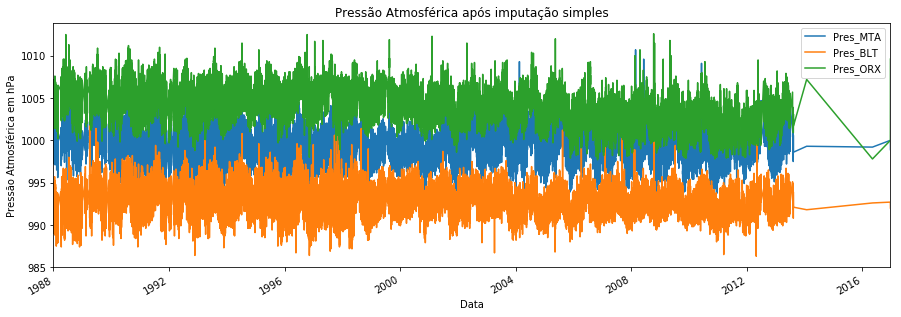

In [639]:
df_final[['Pres_MTA','Pres_BLT','Pres_ORX']].plot(figsize=(15,5),title='Pressão Atmosférica após imputação simples')
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

### Range dos Dados

Devido a variável "Pres_ORX" apresentar uma maior quantidade de dados faltantes (total 3370) para o ultimo periodo da série temporal, iremos considerar apenas os ultimos 25 anos de dados para nossa série final, ou seja, apenas dados dos anos **(1988 a 2013)** serão utilizados para o treinamento da rede. 

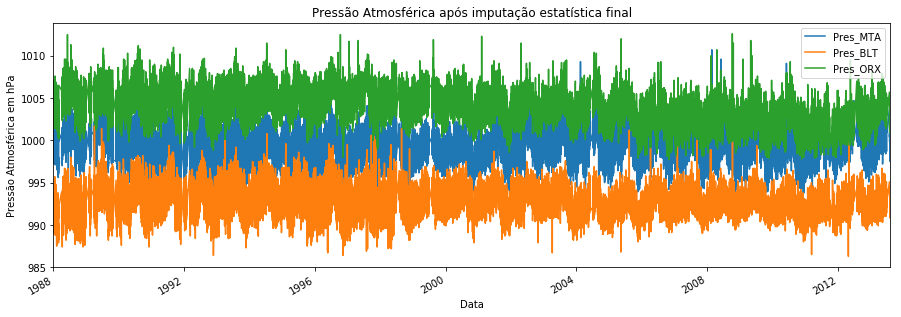

In [640]:
df_final[['Pres_MTA','Pres_BLT','Pres_ORX']]['1988':'2013'].plot(figsize=(15,5),title='Pressão Atmosférica após imputação estatística final')
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

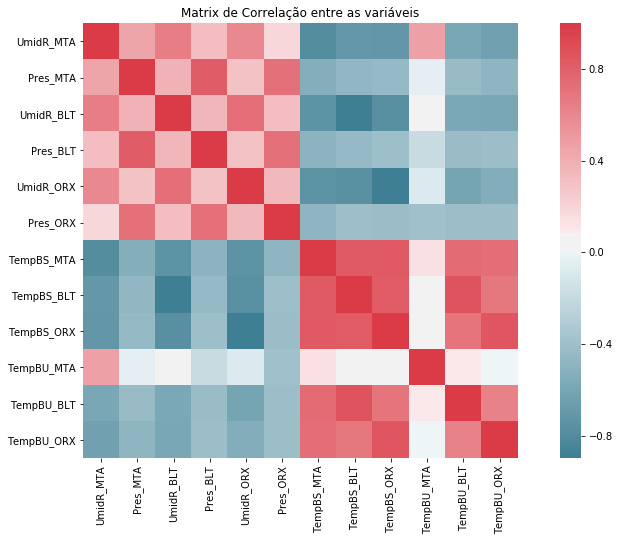

In [641]:
f, ax = plt.subplots(figsize=(15, 8))
plt.title('Matrix de Correlação entre as variáveis')
corr = df_final.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Rede Neural Recorrente

Preparação da Redes

In [642]:
df = df_final
df.head()

,UmidR_MTA,Pres_MTA,UmidR_BLT,Pres_BLT,UmidR_ORX,Pres_ORX,TempBS_MTA,TempBS_BLT,TempBS_ORX,TempBU_MTA,TempBU_BLT,TempBU_ORX
datetime,,,,,,,,,,,,
1988-01-01 00:00:00,65.0,997.4,83.0,990.2,96.0,1003.8,28.7,26.6,24.2,24.4,24.6,23.8
1988-01-01 12:00:00,68.0,999.9,89.0,992.5,89.0,1004.1,27.9,26.4,26.8,23.5,25.0,25.4
1988-01-01 18:00:00,40.0,998.2,62.0,991.0,80.0,1002.7,33.6,31.8,30.0,23.5,26.0,27.2
1988-01-02 00:00:00,74.0,998.3,77.0,990.6,80.0,1002.6,27.4,27.4,28.4,24.0,24.4,25.8
1988-01-02 12:00:00,88.0,999.7,95.0,992.7,88.0,1006.2,25.0,25.0,26.3,23.5,24.4,24.8


In [643]:
print('Quantidade de registros: ', df.values.shape[0], ', Quantidade de atributos: ', df.values.shape[1])

Quantidade de registros:  25961 , Quantidade de atributos:  12


### Adicionando atributos aos dados

In [644]:
# df['Day'] = df.index.dayofyear
# df['Hour'] = df.index.hour

In [645]:
# Reorganizar dados
# df = df_final[['Day','Hour','TempBS_MTA','TempBU_MTA','UmidR_MTA','Pres_MTA',
#                'TempBS_BLT','TempBU_BLT','UmidR_BLT','Pres_BLT',
#                'TempBS_ORX','TempBU_ORX','UmidR_ORX','Pres_ORX']]

df = df_final[['TempBS_MTA','TempBU_MTA','UmidR_MTA','Pres_MTA',
               'TempBS_BLT','TempBU_BLT','UmidR_BLT','Pres_BLT',
               'TempBS_ORX','TempBU_ORX','UmidR_ORX','Pres_ORX']]

In [646]:
df.head()

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
datetime,,,,,,,,,,,,
1988-01-01 00:00:00,28.7,24.4,65.0,997.4,26.6,24.6,83.0,990.2,24.2,23.8,96.0,1003.8
1988-01-01 12:00:00,27.9,23.5,68.0,999.9,26.4,25.0,89.0,992.5,26.8,25.4,89.0,1004.1
1988-01-01 18:00:00,33.6,23.5,40.0,998.2,31.8,26.0,62.0,991.0,30.0,27.2,80.0,1002.7
1988-01-02 00:00:00,27.4,24.0,74.0,998.3,27.4,24.4,77.0,990.6,28.4,25.8,80.0,1002.6
1988-01-02 12:00:00,25.0,23.5,88.0,999.7,25.0,24.4,95.0,992.7,26.3,24.8,88.0,1006.2


### Selecionando Cidade Para Previsão

A cidade selecionada será a cidade de Oriximiná e as variáveis serão **(TempBS_MTA, TempBU_MTA, UmidR_MTA e Pres_MTA)**, sendo que a previsão busca por dados das próximas 24 horas acumuladas.

In [647]:
target_city = 'Oriximina'
target_names = ['TempBS_ORX','TempBU_ORX','UmidR_ORX','Pres_ORX']
shift_days = 10
shift_steps = shift_days * 1 # Número de horas

In [648]:
# Novo dataframe
df_targets = df[target_names].shift(-shift_days)
df_targets

,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
datetime,,,,
1988-01-01 00:00:00,24.4,23.8,95.0,1006.5
1988-01-01 12:00:00,27.6,25.6,85.0,1004.3
1988-01-01 18:00:00,26.0,25.2,94.0,1004.2
1988-01-02 00:00:00,24.6,24.0,95.0,1006.4
1988-01-02 12:00:00,29.0,26.4,80.0,1004.9
...,...,...,...,...
2013-08-12 00:00:00,NaN,NaN,NaN,NaN
2014-01-25 18:00:00,NaN,NaN,NaN,NaN
2016-05-06 18:00:00,NaN,NaN,NaN,NaN


### DataFrame para Vetor

Para entrada da rede é necessário converter o DataFrame (Pandas) para um vetor, isso é feito através da biblioteca NumPy, é necessário remover a ultima parte que contem valores NaN

In [649]:
# Vetor de ENTRADA
x_data = df.values[0:-shift_steps]

print('Tipo dos dados: ',type(x_data))
print("Tamanho de entradas (observações) e número de atributos ", x_data.shape)

Tipo dos dados:  <class 'numpy.ndarray'>
Tamanho de entradas (observações) e número de atributos  (25951, 12)


In [650]:
# Vetor de saída a partir do DataFrame target (Cidade Odense), ultimas linhas para previsão
y_data = df_targets.values[:-shift_steps]
print('Tipo dos dados: ',type(y_data))
print("Tamanho de saída (observações) e número de atributos ", y_data.shape)

Tipo dos dados:  <class 'numpy.ndarray'>
Tamanho de saída (observações) e número de atributos  (25951, 4)


In [651]:
print('Tamanho do Vetor de Entrada: ', len(x_data))
print('Tamanho do Vetor de Saída: ', len(y_data))

Tamanho do Vetor de Entrada:  25951
Tamanho do Vetor de Saída:  25951


#### Treinamento e Teste

Para este experimento serão selecionados 90% dos dados para treinamento e 10% para teste

In [652]:
# numero de dados de oberservação
num_data = len(x_data)

# fração para treinamento
train_split = 0.9

# número de elementos para treinamento
num_train = int(train_split * num_data)
print('Número de elementos para treinamento: ', num_train)
num_test = num_data - num_train
print('Número de elementos para teste: ', num_test)

Número de elementos para treinamento:  23355
Número de elementos para teste:  2596


In [653]:
# vetores de entrada para teste e treinamento
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

In [654]:
# vetores de saída para teste e treinamento
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [655]:
# numero de atributos de entrada
num_x_signals = x_data.shape[1]
print('Atributos de entrada: ', num_x_signals)
num_y_signals = y_data.shape[1]
print('Atributos de saída: ', num_y_signals)

Atributos de entrada:  12
Atributos de saída:  4


### Normalização dos dados

Os dados de entrada e saída estão em escalas diferentes, variando de valores negativos (ex: temperatura) a valores altos (pressão), por tanto, é necessário aplicar uma normalização dos dados para que esta variação seja de 0 à 1 pois as redes neurais trabalham melhor nesta escala, para isso é possível utilizar a função MinMaxScaler da biblioteca scikit-learn.

In [656]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 18.6
Max: 1012.6


In [657]:
# objeto para os sinais de entrada
x_scaler = MinMaxScaler()

In [658]:
# função para normalização dos dados de entrada do treinamento
x_train_scaled = x_scaler.fit_transform(x_train)

In [659]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [660]:
# o mesmo objeto x_caler é utilizado para os valores de teste
x_test_scaled = x_scaler.transform(x_test)

In [661]:
# outra funcao para normalização dos dados de treinamento e teste da saída
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [662]:
print("Min:", np.min(y_train_scaled))
print("Max:", np.max(y_train_scaled))

Min: 0.0
Max: 1.0


#### Geração de dados em lote
Os dados já estão preparados de forma vetorial e bi-dimensional, porém para o treinamento é possivel melhorar a forma de entrada para rede, organizando os mesmos em lotes, a função a baixo cria o melhor lote para sub-sequência dos dados de forma aleatória.

In [663]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Quanto maior o tamanho do lote, maior a carga de trabalhos para os processadores, por tanto é necessário que o valor do batch_size seja de acordo com um valor ideial para o processodor e memória.

In [664]:
# Tamanho do batch
batch_size = 128

In [665]:
# Sequência para cada batch
sequence_length = 720

In [666]:
# gerador de dados em lote
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [667]:
# teste para o gerador de dados em lote
x_batch, y_batch = next(generator)

In [668]:
x_train_scaled.shape

(23355, 12)

In [669]:
print(x_batch.shape)
print(y_batch.shape)

(128, 720, 12)
(128, 720, 4)


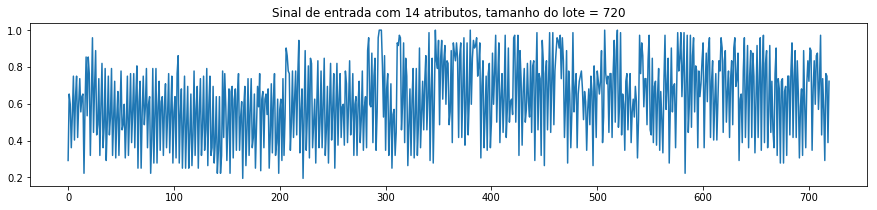

In [670]:
batch = 0   # Primeiro bloco 
signal = 2  #Sinal a partir dos dados com 14 atributos
seq = x_batch[batch, :, signal]
plt.figure(figsize=(15,3))
plt.title(label='Sinal de entrada com 14 atributos, tamanho do lote = 720')
plt.plot(seq)
plt.show()

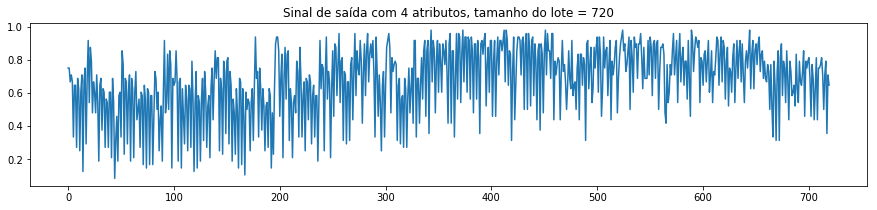

In [671]:
seq = y_batch[batch, :, signal]
plt.figure(figsize=(15,3))
plt.title(label='Sinal de saída com 4 atributos, tamanho do lote = 720')
plt.plot(seq)
plt.show()

### Dados de validação

Uma rede neural pode treinar rapidamente várias epocas, no entanto existe um risco de "overfitting" sobre o modelo treinado e para que não haja uma generalização no treinamento o gerador de lote seleciona aleatoriamente uma sequência curta de dados e o utiliza durante o treinamento, porém para validação é necessário percorrer toda a sequência do conjunto de testes e medir a precisão da previsão para toda sequência de teste e treinamento. Por tanto, a variavel "validation_data" reune os dois vetores de entrada e saida para que possa validar os resultados.

In [672]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [673]:
print('Formato dos dados de validação entrada: ', validation_data[0].shape )
print('Formato dos dados de validação saída: ', validation_data[1].shape )

Formato dos dados de validação entrada:  (1, 2596, 12)
Formato dos dados de validação saída:  (1, 2596, 4)


### Rede Neural Recorrente

O conceito básico por trás de uma Rede Neural Recorrente (sigla para Recurrent Neural Network - RNN) é a sua Unidade Recorrente (UR), existem algumas variações de unidades recorrentes, como a LSTM (do inglês Long-Short-Term-Memory) e a Gated Recurrent Unit (GRU). Para este tutorial iremos utilizar a implementação da GRU disponivel na biblioteca do Keras.

A ideia básica da GRU é que sua UR possui um valor interno que é atualizado sempre que a unidade recebe uma nova entrada, esse estado interno serve como uma memória que armazena os valores para o treinamento da rede usando um gradiente descendente. O novo valor do estado depente do valor antigo e de sua entrada atual.

Para treinar a UR, é necessário alterar gradualmente as matrizes de peso de cada entrada para que a UR produza a saída desejada para uma sequência de entrada, isso é feito automaticamente no TensorFlow.

In [674]:
# tensorflow e keras engine
model = Sequential()

Após o modelo podemos adicionar a RU para à rede, neste caso teram 512 saídas para cada intervalo de tempo da sequência, um fator importante é que essa será a primeira camada do modelo e o Keras precisa reconhecer o formato da entrada, ou seja, a entrada será um lote de sequências com um comprimento arbitrário onde cada observação possui 14 sinais de entrada (num_x_signals).

In [675]:
print('Numéro de sinais de entrada:',num_x_signals)

Numéro de sinais de entrada: 12


### LSTM MODEL

In [676]:
model_lstm = Sequential()
model_lstm.add(LSTM(75,
                return_sequences=True,
                input_shape=(None,x_train_scaled.shape[1])))
model_lstm.add(Dropout(0.2))

In [677]:
model.add(GRU(units=75,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dropout(0.2,))

A GRU íra gerar um lote de sequências com 512 valores, e desejamos prever três saídas, portanto adicionamos mais uma camada densa que mapeia esses 512 valores para apenas 4 saídas, esses sinais foram limitados a estar entre 0 e 1 devido a função scaler, então também é necessário limitar a saída da rede para uma função de ativação sigmoid que limita o valor de saída entre 0 e 1.

O problema ao usar uma função de ativação Sigmoid é que a função irá mapear os valores de acordo com a função scaler e irá gerar valores entre -20 a 0 e +30 a 1 por exemplo, portanto, se limitarmos a saída da rede a 0 e 1 usando a função sigmoid os valores mapeados teram uma escala de variação de -20 e +30. Em vez disso podemos utilizar uma função de ativação linear para a saída, que permite que estes valores tenham uma saída arbitrária intependente dessa escala.

In [678]:
from tensorflow.python.keras.initializers import RandomUniform

# Faixa de variação randomica para função linear.
init = RandomUniform(minval=-0.09, maxval=0.09)

model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))
    
model_lstm.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Função de perda

Para a função de perda (Loss) será utilizado o Erro Quadrático Médio (do inglês Mean Squared Error sigla MSE) isso irá medir quanto a saída do modelo corresponde aos valores verdadeiros do sinal de saída. Porém, no início de uma sequência, o modelo só viu sinais de entrada por durante algumas etapas e sua saída gerada pode ser muito imprecisa e o uso do valor da perda nas etapas iniciais pode fazer com que o modelo distorça a saída anterior para resolver isso atribuímos ao modelo um "warmup-period" de 50 etapas no tempo em que não será utilizaada sua precisão na função de perda com objetivo de melhorar a precisão nas etapas anteriores.

In [679]:
# periodos para warmup-period
warmup_steps = 50

In [680]:
def loss_mse_warmup(y_true, y_pred):
    
    """
    Calcula MSE entre as saídas verdadeiras e saídas previsas
    porém ignora a sequência inicial de aquecimento.
    
    y_true é a saída desejada.
    y_pred é a saída do modelo.
    """

    # tamanho para os dois tensores de entrada:
    #  Ignora parte da sequecência "warmup", tomando como medida parte do tamanho dos tensores

    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # Calcula o MSE para cada valor de tensores
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

#### Modelo de otimização

O RMSprop é um método para otimização com taxa adaptativa que usa uma média movel exponencial e será o modelo inicial para otimização.

In [681]:
optimizer = RMSprop(lr=1e-3)

Em seguida esse modelo será compilado pelo Keras e estara pronto a parte do treinamento.



In [682]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 75)          19800     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 75)          0         
_________________________________________________________________
dense_7 (Dense)              (None, None, 4)           304       
Total params: 20,104
Trainable params: 20,104
Non-trainable params: 0
_________________________________________________________________


In [683]:
model_lstm.compile(loss=loss_mse_warmup, optimizer=optimizer)
model_lstm.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 75)          26400     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 75)          0         
_________________________________________________________________
dense_8 (Dense)              (None, None, 4)           304       
Total params: 26,704
Trainable params: 26,704
Non-trainable params: 0
_________________________________________________________________


Este será um modelo relativamente pequeno com apenas duas camadas, e sua forma de saída será (None, None, 4) que significa que o modelo irá produzir um lote com um número de sequências onde cada uma corresponde a observação de 4 sinais que estão sendo previstos.

#### Funções de Callback

Durante o treinamento é necessário salvar os checkpoints e os registros do processo para o TensorBoard criando funções de callback para o Keras, essa função irá escrever checkpoints durante o treinamento

In [684]:
path_checkpoint = 'amazonia_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [685]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [686]:
callback_tensorboard = TensorBoard(log_dir='../amazonia_logs/',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_images=True)

In [687]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [688]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [689]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

### Treinamento da Rede Neural Recorrente

Treinamento da Rede Neural Recorrente
O próximo bloco de códigos irá treinar a rede neural, onde uma única época não corresponde a um único processamento mas sim a um lote gerado pela função que empacota e seleciona de forma aleatória uma sub-sequência do conjunto de treinamento.

Esse modelo foi treinado sobre um processador Intel Core i7

In [690]:
%%time
gru_history = model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
  1/100 [..............................] - ETA: 1:53 - loss: 0.0206
Epoch 00001: val_loss improved from inf to 0.02057, saving model to amazonia_checkpoint.keras
100/100 [==============================] - 83s 832ms/step - loss: 0.0372 - val_loss: 0.0206
Epoch 2/20
  1/100 [..............................] - ETA: 1:01 - loss: 0.0156
Epoch 00002: val_loss improved from 0.02057 to 0.01559, saving model to amazonia_checkpoint.keras
100/100 [==============================] - 81s 806ms/step - loss: 0.0204 - val_loss: 0.0156
Epoch 3/20
  1/100 [..............................] - ETA: 1:01 - loss: 0.0160
Epoch 00003: val_loss did not improve from 0.01559

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 80s 799ms/step - loss: 0.0178 - val_loss: 0.0160
Epoch 4/20
  1/100 [..............................] - ETA: 1:04 - loss: 0.0150
Epoch 00004: val_loss improved from 0.01559 to 0.01498, saving model to amazonia_ch

In [691]:
%%time
lstm_history = model_lstm.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
  1/100 [..............................] - ETA: 2:08 - loss: 0.0275
Epoch 00001: val_loss did not improve from 0.01407
100/100 [==============================] - 101s 1s/step - loss: 0.1117 - val_loss: 0.0275
Epoch 2/20
  1/100 [..............................] - ETA: 1:11 - loss: 0.0228
Epoch 00002: val_loss did not improve from 0.01407
100/100 [==============================] - 96s 960ms/step - loss: 0.0334 - val_loss: 0.0228
Epoch 3/20
  1/100 [..............................] - ETA: 1:08 - loss: 0.0194
Epoch 00003: val_loss did not improve from 0.01407
100/100 [==============================] - 96s 958ms/step - loss: 0.0287 - val_loss: 0.0194
Epoch 4/20
  1/100 [..............................] - ETA: 1:11 - loss: 0.0191
Epoch 00004: val_loss did not improve from 0.01407
100/100 [==============================] - 97s 969ms/step - loss: 0.0272 - val_loss: 0.0191
Epoch 5/20
  1/100 [..............................] - ETA: 1:10 - loss: 0.0190
Epoch 00005: val_loss did not impro

### Carregando os checkpoints

Devido o uso da função call back que faz uma parada antecipada no treinamento, é possível que o desempenho do modelo piore depois de várias épocas antes da interrupção do treinamento, ou sejá, é necessário carregar o último ponto de verificação salvo pois esse terá o melhor desempenho para os pesos de treinamento.

In [692]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### Desempenho para o conjunto de teste

É possível avaliar o desempenho do modelo para os dados de teste

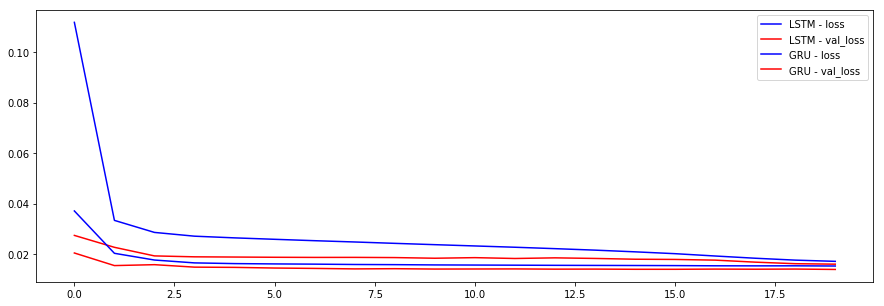

In [693]:
plt.figure(figsize=(15,5))
plt.plot(lstm_history.history['loss'], label='LSTM - loss',color='blue')
plt.plot(lstm_history.history['val_loss'], label='LSTM - val_loss',color='red')
plt.plot(gru_history.history['loss'], label='GRU - loss',color='blue')
plt.plot(gru_history.history['val_loss'], label='GRU - val_loss',color='red')
plt.legend()

In [694]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 1s 619ms/sample - loss: 0.0141


In [695]:
print("loss (test-set):", result)

loss (test-set): 0.014068582095205784


In [696]:
# Caso hajam mais métricas é possível utiliza-las
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

#### Geração de previsões

A função a baixo auxlia na visualização dos sinais de saída previstos e compara-los com os valores verdadeiros Esta função auxiliar traça os sinais de saída previstos e verdadeiros.

In [710]:
def output_frame_GRU(start_idx, length, train=True):
    """
    :param start_idx: Indice inicial da série temporal.
    :param length: Comprimento da sequência, número de elementos após o indice inicial.
    :param train: Valor Booleano para utilizar dados treinamento ou teste.
    """
    
    if train == True:
        # Usar dados de treinamento.
        x = x_train_scaled
        y_true = y_train
    else:
        # Usar dados de teste.
        x = x_test_scaled
        y_true = y_test
    
    # Indice final para sequência, tempo inicial mais comprimento.
    end_idx = start_idx + length
    
    #Selecione a seqüência do índice inicial especificado e comprimento.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Sinais de entrada para o modelo.
    x = np.expand_dims(x, axis=0)

    # Usar o modelo para prever os sinais de saída.
    y_pred = model.predict(x)
    
    # A saída do modelo tem valores entre 1 e 0.
    # Será necessário aplicar uma função de mapeamento inverso para deixar os dados rescalados
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    output = pd.DataFrame()
    output['Prev_TempBS_ORX'] = y_pred_rescaled[:,0]
    output['Prev_TempBU_ORX'] = y_pred_rescaled[:,1]
    output['Prev_UmidR_ORX'] = y_pred_rescaled[:,2]
    output['Prev_Pres_ORX'] = y_pred_rescaled[:,3]
    output['Datetime'] = df_targets.index[-start_idx:-start_idx+length]
    output = output.set_index('Datetime')
    
    return output

In [713]:
def output_frame_LSTM(start_idx, length, train=True):
    """
    :param start_idx: Indice inicial da série temporal.
    :param length: Comprimento da sequência, número de elementos após o indice inicial.
    :param train: Valor Booleano para utilizar dados treinamento ou teste.
    """
    
    if train == True:
        # Usar dados de treinamento.
        x = x_train_scaled
        y_true = y_train
    else:
        # Usar dados de teste.
        x = x_test_scaled
        y_true = y_test
    
    # Indice final para sequência, tempo inicial mais comprimento.
    end_idx = start_idx + length
    
    #Selecione a seqüência do índice inicial especificado e comprimento.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Sinais de entrada para o modelo.
    x = np.expand_dims(x, axis=0)

    # Usar o modelo para prever os sinais de saída.
    y_pred = model_lstm.predict(x)
    
    # A saída do modelo tem valores entre 1 e 0.
    # Será necessário aplicar uma função de mapeamento inverso para deixar os dados rescalados
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    output = pd.DataFrame()
    output['Prev_TempBS_ORX'] = y_pred_rescaled[:,0]
    output['Prev_TempBU_ORX'] = y_pred_rescaled[:,1]
    output['Prev_UmidR_ORX'] = y_pred_rescaled[:,2]
    output['Prev_Pres_ORX'] = y_pred_rescaled[:,3]
    output['Datetime'] = df_targets.index[-start_idx:-start_idx+length]
    output = output.set_index('Datetime')
    
    return output

In [767]:
length = 200
start_idx = 500

In [768]:
# apenas com os dados de treinamento
saida_LSTM = output_frame_LSTM(start_idx=start_idx, length=length, train=False)
saida_GRU = output_frame_GRU(start_idx=start_idx, length=length, train=False)
saida_LSTM.head()

,Prev_TempBS_ORX,Prev_TempBU_ORX,Prev_UmidR_ORX,Prev_Pres_ORX
Datetime,,,,
2010-11-28 12:00:00,23.601204,22.594574,57.577057,999.285034
2010-11-28 18:00:00,24.917053,23.216978,58.403915,999.651306
2010-11-29 00:00:00,25.293402,23.391035,61.548470,1000.024963
2010-11-29 12:00:00,26.199520,23.836767,62.326874,1000.221252
2010-11-29 18:00:00,26.107258,23.833494,65.594505,1000.524353


In [769]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [770]:
x = df_targets['TempBS_ORX'][-start_idx:-start_idx+length].values.reshape(-1,1)
y_L = saida_LSTM['Prev_TempBS_ORX'].values.reshape(-1,1)
y_G = saida_GRU['Prev_TempBS_ORX'].values.reshape(-1,1)

xscaler = MinMaxScaler()

scalx = xscaler.fit_transform(x)
scaly_L = xscaler.fit_transform(y_L)
scaly_G = xscaler.fit_transform(y_G)

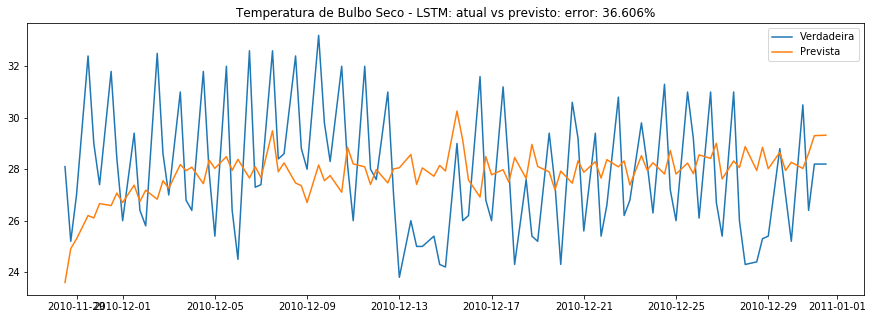

In [771]:
plt.figure(figsize=(15,5))
plt.plot(df_targets['TempBS_ORX'][-start_idx:-start_idx+length], label='Verdadeira')
plt.plot(saida_LSTM['Prev_TempBS_ORX'], label='Prevista')
rmse = sqrt(mean_squared_error(scalx,scaly_L))*100
plt.title('Temperatura de Bulbo Seco - LSTM: atual vs previsto: error: %.3f' %rmse + '%')
plt.legend()
plt.show()

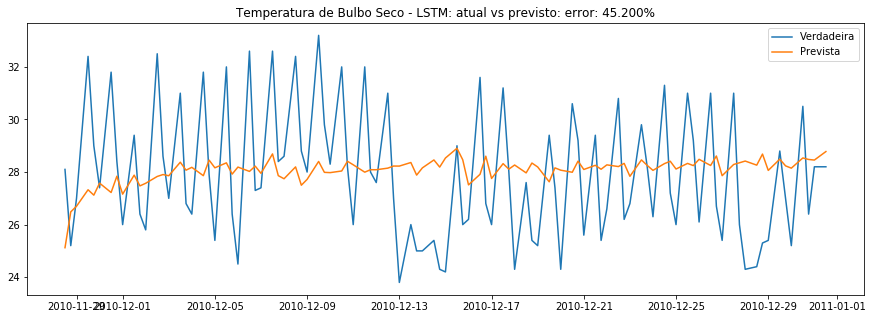

In [772]:
plt.figure(figsize=(15,5))
plt.plot(df_targets['TempBS_ORX'][-start_idx:-start_idx+length], label='Verdadeira')
plt.plot(saida_GRU['Prev_TempBS_ORX'], label='Prevista')
rmse = sqrt(mean_squared_error(scalx,scaly_G))*100
plt.title('Temperatura de Bulbo Seco - LSTM: atual vs previsto: error: %.3f' %rmse + '%')
plt.legend()
plt.show()

In [773]:
x = df_targets['TempBU_ORX'][-start_idx:-start_idx+length].values.reshape(-1,1)
y = saida_GRU['Prev_TempBU_ORX'].values.reshape(-1,1)

xscaler = MinMaxScaler()

scalx = xscaler.fit_transform(x)
scaly = xscaler.fit_transform(y)

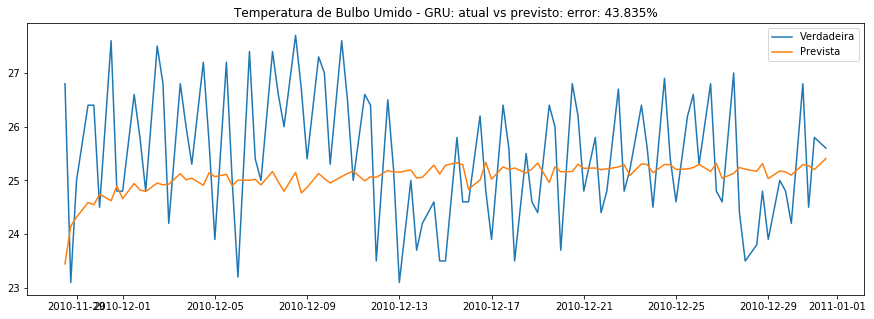

In [774]:
plt.figure(figsize=(15,5))
plt.plot(df_targets['TempBU_ORX'][-start_idx:-start_idx+length], label='Verdadeira')
plt.plot(saida_GRU['Prev_TempBU_ORX'], label='Prevista')
rmse = sqrt(mean_squared_error(scalx,scaly))*100
plt.title('Temperatura de Bulbo Umido - GRU: atual vs previsto: error: %.3f' %rmse + '%')
plt.legend()
plt.show()

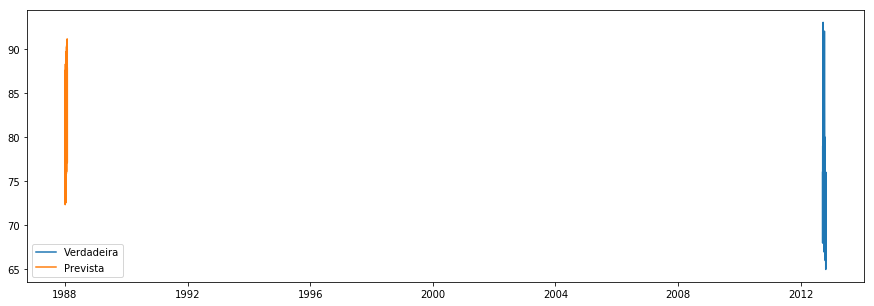

In [705]:
plt.figure(figsize=(15,5))
plt.plot(df_targets['UmidR_ORX'][-start_idx:-start_idx+length], label='Verdadeira')
plt.plot(saida['Prev_UmidR_ORX'], label='Prevista')
plt.legend()

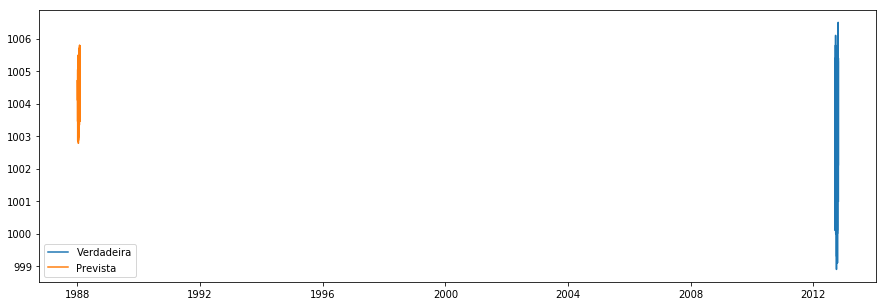

In [706]:
plt.figure(figsize=(15,5))
plt.plot(df_targets['Pres_ORX'][-start_idx:-start_idx+length], label='Verdadeira')
plt.plot(saida['Prev_Pres_ORX'], label='Prevista')
plt.legend()

In [707]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model_lstm.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [708]:
# plot_comparison(start_idx=100000, length=1000, train=True)

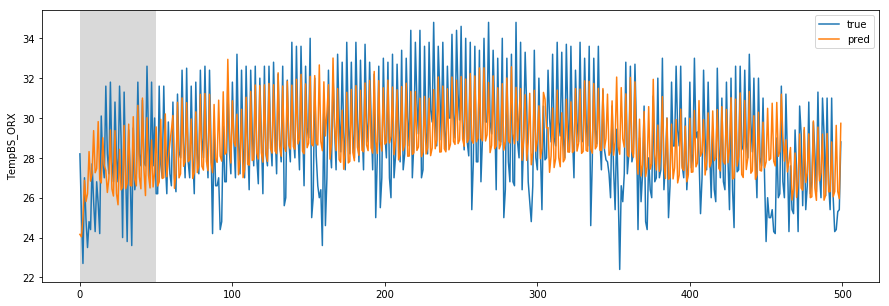

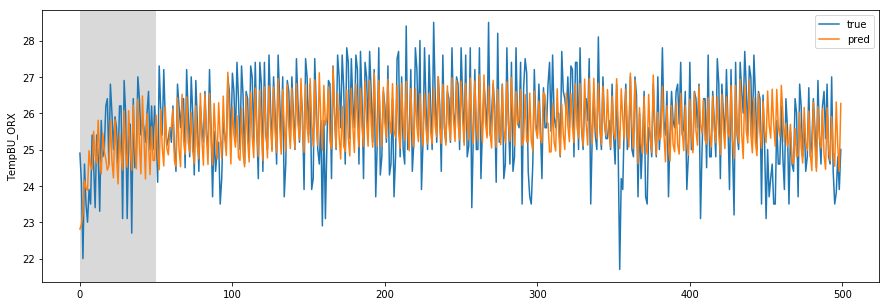

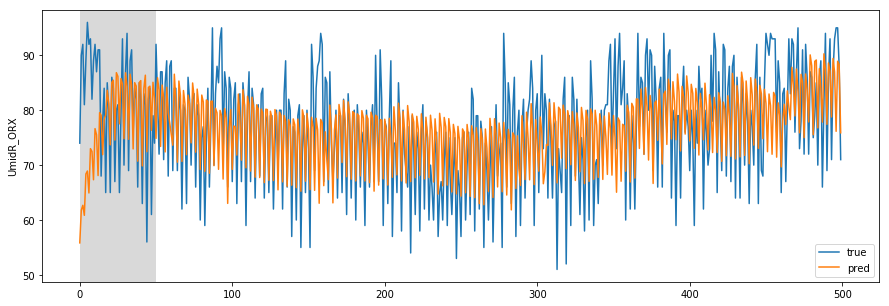

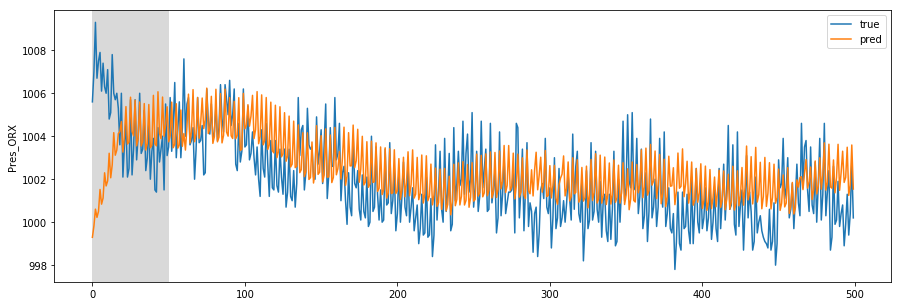

In [709]:
plot_comparison(start_idx=200, length=500, train=False)